<a href="https://www.kaggle.com/code/eslamsharoud/supplement-sales-data?scriptVersionId=238646642" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/supplement-sales-data/Supplement_Sales_Weekly_Expanded.csv


# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Import libraries</p>


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

import joblib


# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Load Dataset</p>


In [3]:
data_path=r'/kaggle/input/supplement-sales-data/Supplement_Sales_Weekly_Expanded.csv'
df=pd.read_csv(data_path)
df.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
1,2020-01-06,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2,2020-01-06,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
3,2020-01-06,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
4,2020-01-06,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb


In [4]:
df.tail()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
4379,2025-03-31,Melatonin,Sleep Aid,160,47.79,7646.40,0.21,1,USA,iHerb
4380,2025-03-31,Biotin,Vitamin,154,38.12,5870.48,0.22,1,UK,Walmart
4381,2025-03-31,Green Tea Extract,Fat Burner,139,20.40,2835.60,0.12,3,USA,iHerb
4382,2025-03-31,Iron Supplement,Mineral,154,18.31,2819.74,0.23,2,Canada,Amazon
4383,2025-03-31,Electrolyte Powder,Hydration,178,39.12,6963.36,0.23,0,UK,iHerb


# <p style="padding:10px;background-color:green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">EDA</p>


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4384 entries, 0 to 4383
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4384 non-null   object 
 1   Product Name    4384 non-null   object 
 2   Category        4384 non-null   object 
 3   Units Sold      4384 non-null   int64  
 4   Price           4384 non-null   float64
 5   Revenue         4384 non-null   float64
 6   Discount        4384 non-null   float64
 7   Units Returned  4384 non-null   int64  
 8   Location        4384 non-null   object 
 9   Platform        4384 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 342.6+ KB


In [6]:
df.isna().sum()

Date              0
Product Name      0
Category          0
Units Sold        0
Price             0
Revenue           0
Discount          0
Units Returned    0
Location          0
Platform          0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Units Sold,4384.0,150.200274,12.396099,103.0,142.0000,150.00,158.0000,194.00
Price,4384.0,34.781229,14.198309,10.0,22.5975,34.72,46.7125,59.97
Revenue,4384.0,5226.569446,2192.491946,1284.0,3349.3725,5173.14,7009.9600,10761.85
Discount,4384.0,0.124398,0.071792,0.0,0.0600,0.12,0.1900,0.25
Units Returned,4384.0,1.531478,1.258479,0.0,1.0000,1.00,2.0000,8.00


In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
15,2020-01-06,Electrolyte Powder,Hydration,154,35.92,5531.68,0.04,2,USA,Amazon
14,2020-01-06,Iron Supplement,Mineral,149,42.97,6402.53,0.22,2,Canada,iHerb
13,2020-01-06,Green Tea Extract,Fat Burner,143,31.88,4558.84,0.06,3,UK,Walmart
12,2020-01-06,Biotin,Vitamin,159,28.79,4577.61,0.10,1,UK,iHerb


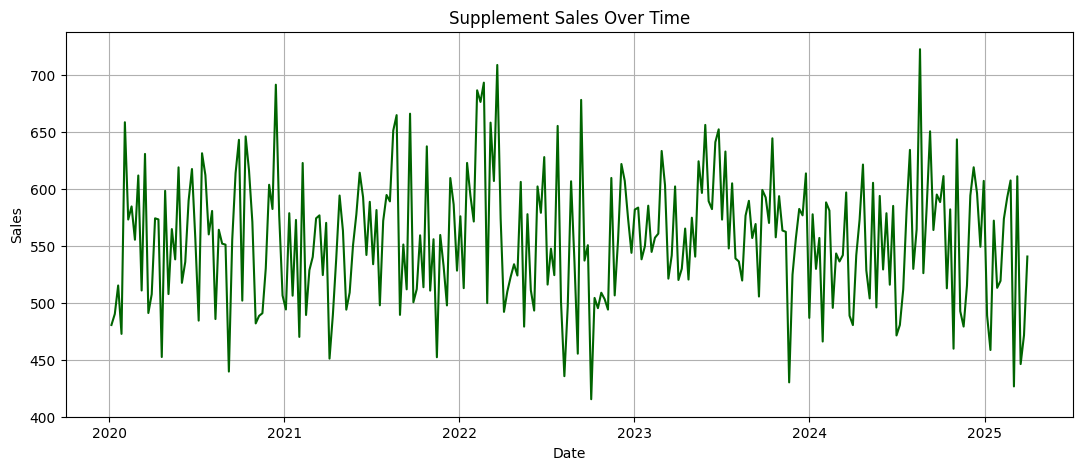

In [9]:
plt.figure(figsize=(13, 5))
df_price=df.groupby('Date')['Price'].sum().reset_index()
sns.lineplot(x='Date',y='Price',data=df_price,color='darkgreen')
plt.title('Supplement Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


In [10]:
top_products = df.groupby('Product Name')['Revenue'].sum().sort_values(ascending=False)
top_products

Product Name
Biotin                1486798.62
Zinc                  1482546.95
Pre-Workout           1477183.78
BCAA                  1464819.63
Fish Oil              1451065.87
Green Tea Extract     1440900.05
Collagen Peptides     1433297.24
Creatine              1432518.40
Iron Supplement       1431582.41
Whey Protein          1422194.85
Vitamin C             1421998.07
Electrolyte Powder    1411951.38
Ashwagandha           1405700.79
Melatonin             1397315.79
Multivitamin          1391427.99
Magnesium             1361978.63
Name: Revenue, dtype: float64

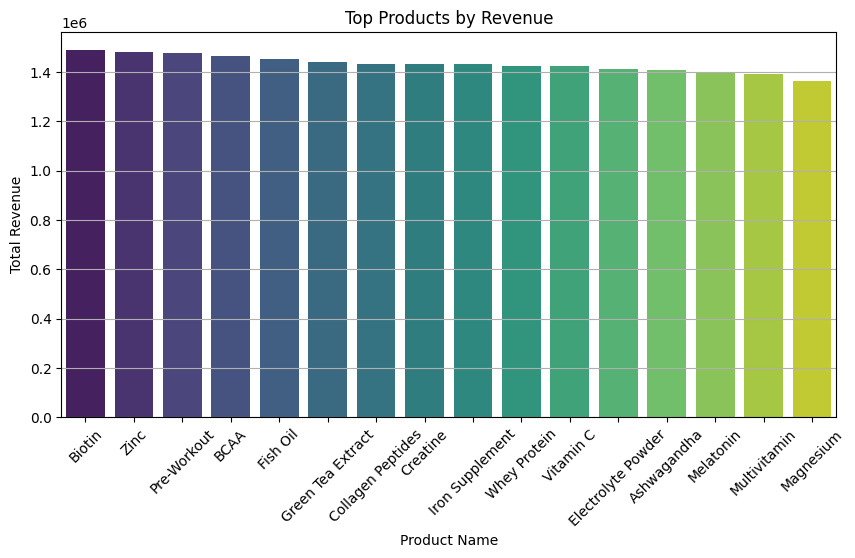

In [11]:
plt.figure(figsize=(10, 5))

idx=top_products.index
vals=top_products.values
sns.barplot(x=idx,y=vals,palette='viridis')

plt.title("Top Products by Revenue")
plt.xticks(rotation=45)
plt.ylabel("Total Revenue")
plt.grid(axis='y')
plt.show()

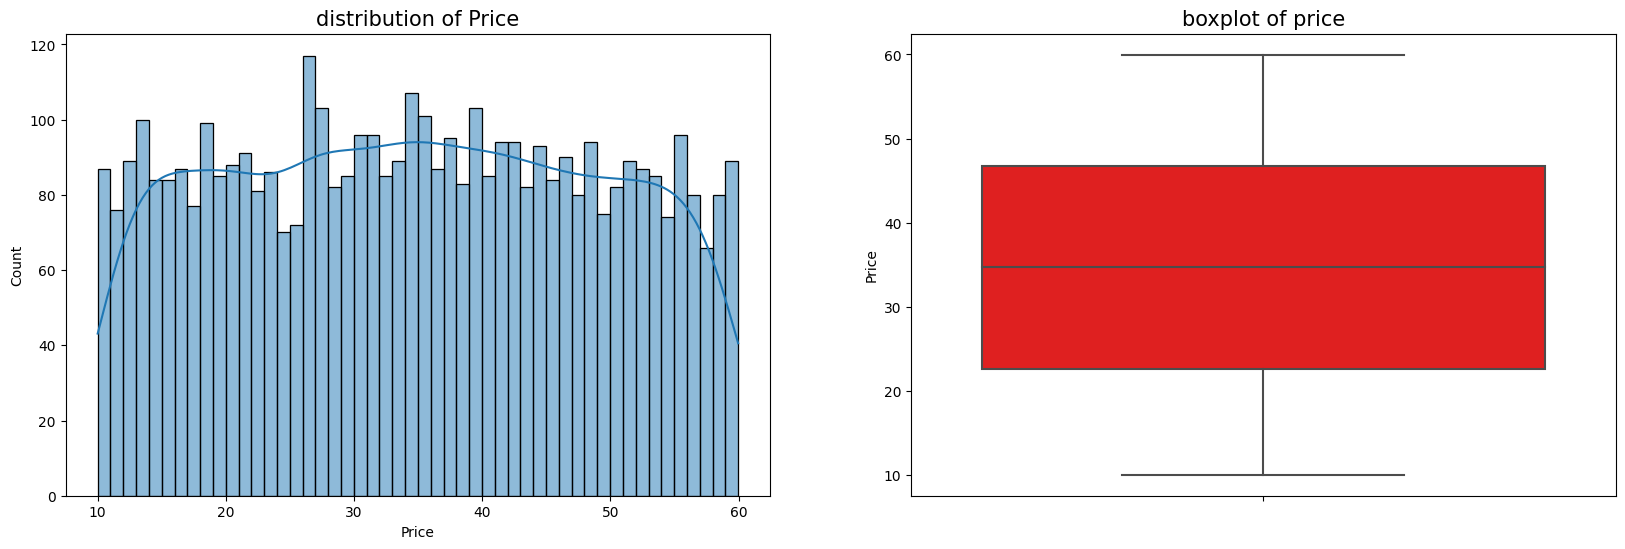

In [12]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.histplot(x=df['Price'],bins=50,kde=True)
plt.title('distribution of Price',fontsize=15)

plt.subplot(1,2,2)
sns.boxplot(y=df['Price'],color='red')
plt.title('boxplot of price',fontsize=15)

plt.show()

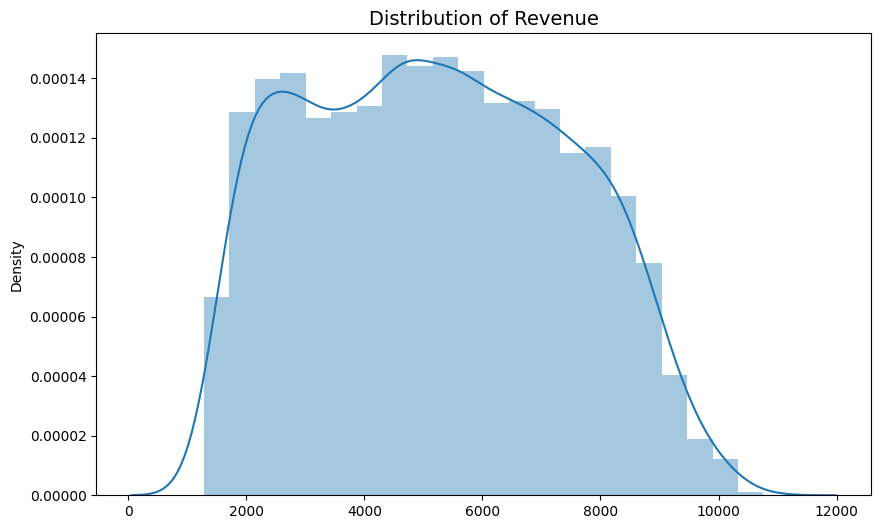

In [13]:
plt.figure(figsize=(10,6))
sns.distplot(x=df['Revenue'])
plt.title('Distribution of Revenue', fontsize=14)
plt.show()

In [14]:
df['Category'].value_counts().sort_values()


Category
Sleep Aid      274
Herbal         274
Fat Burner     274
Hydration      274
Omega          274
Amino Acid     274
Performance    548
Protein        548
Mineral        822
Vitamin        822
Name: count, dtype: int64

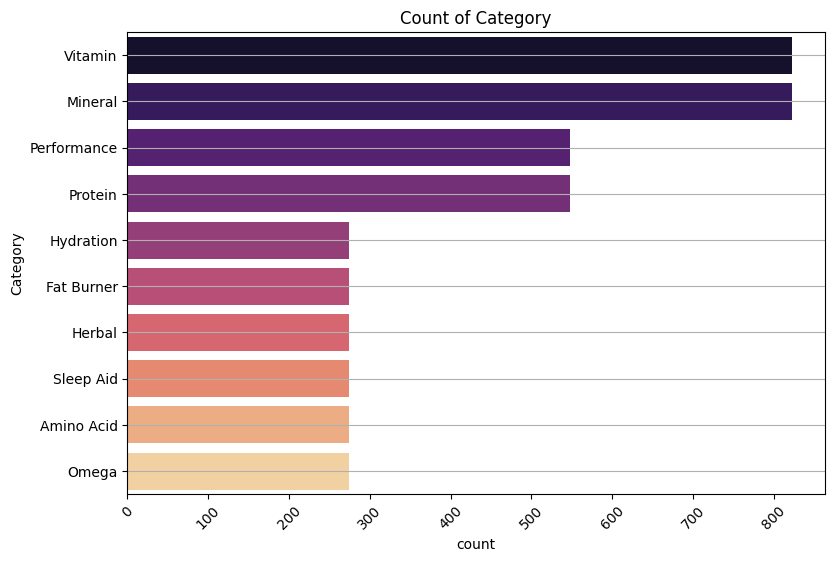

In [15]:
plt.figure(figsize=(9,6))
sns.countplot(y=df['Category']
              ,palette='magma',
              order=df['Category'].value_counts().index

             )
plt.xticks(rotation=45)
plt.title('Count of Category')
plt.grid(True,axis='y')

<Axes: xlabel='Units Sold', ylabel='Revenue'>

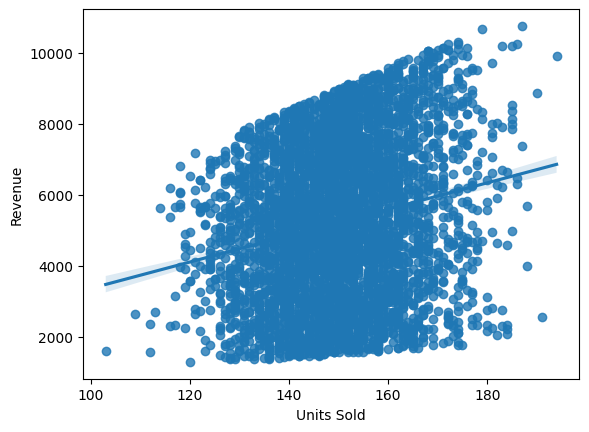

In [16]:
sns.regplot(x='Units Sold',y='Revenue',data=df)

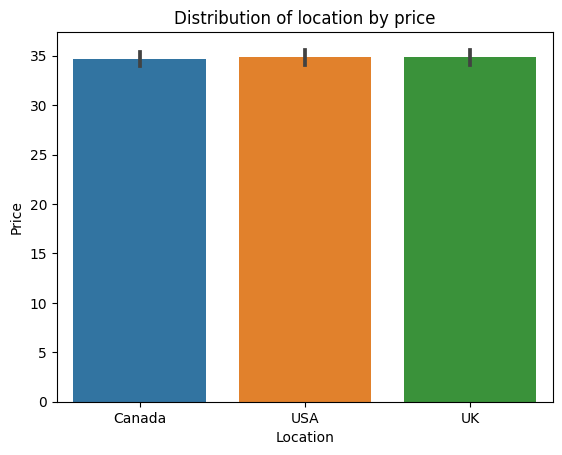

In [17]:
sns.barplot(x='Location',y='Price',data=df)
plt.title("Distribution of location by price")
plt.show()

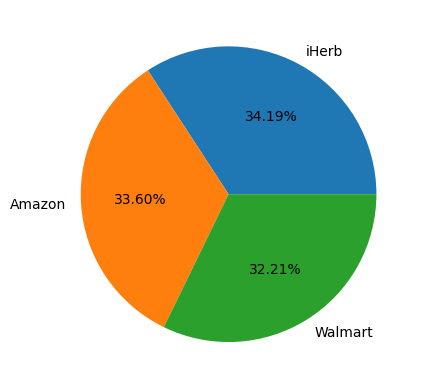

In [18]:
# pie plot
df['Platform'].value_counts()
plt.pie(df['Platform'].value_counts().values,
        labels=df['Platform'].value_counts().index,
        autopct="%.2f%%"
)
plt.show()

# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Time Series</p>


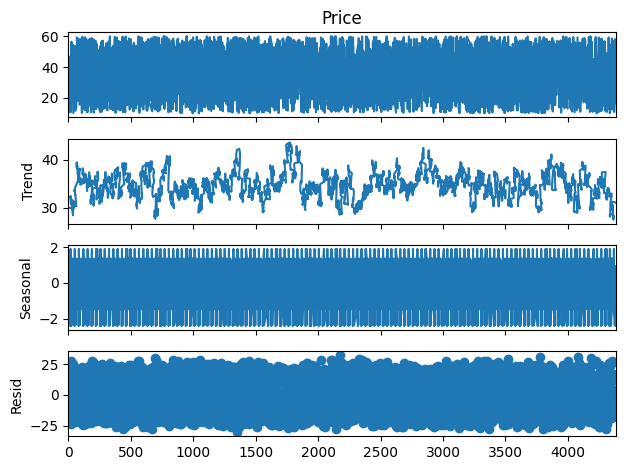

In [19]:
# Decompose the time series
result = seasonal_decompose(df['Price'], model='additive', period=30)  # assume monthly data
result.plot()
plt.show()

In [20]:
# Fit ARIMA model
model = ARIMA(df['Price'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4384
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -17852.034
Date:                Thu, 08 May 2025   AIC                          35710.069
Time:                        22:20:33   BIC                          35729.225
Sample:                             0   HQIC                         35716.828
                               - 4384                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0025      0.015      0.170      0.865      -0.027       0.032
ma.L1         -0.9999      0.004   -242.880      0.000      -1.008      -0.992
sigma2       201.6191      6.660     30.273      0.0

In [21]:
# Forecast next 30 days
forecast = model_fit.forecast(steps=30)
forecast

4384    34.789441
4385    34.778426
4386    34.778398
4387    34.778398
4388    34.778398
4389    34.778398
4390    34.778398
4391    34.778398
4392    34.778398
4393    34.778398
4394    34.778398
4395    34.778398
4396    34.778398
4397    34.778398
4398    34.778398
4399    34.778398
4400    34.778398
4401    34.778398
4402    34.778398
4403    34.778398
4404    34.778398
4405    34.778398
4406    34.778398
4407    34.778398
4408    34.778398
4409    34.778398
4410    34.778398
4411    34.778398
4412    34.778398
4413    34.778398
Name: predicted_mean, dtype: float64

In [22]:
# plt.figure(figsize=(12, 5))
# plt.plot(df['Price'].loc[4353:], label='Historical')
# plt.plot(forecast, label='Forecast',linestyle='--' )
# plt.title('Sales Forecast')
# plt.legend()
# plt.show()

# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Split Data</p>


In [23]:
#split data to train - test - valid
X = df.drop(columns='Revenue',axis=1)
y = df['Revenue']
X=X.drop('Date',axis=1)

X_train_full,X_test,y_train_full,y_test=train_test_split(X,y,test_size=.2,random_state=42)

X_train,X_valid,y_train,y_valid=train_test_split(X_train_full,y_train_full , test_size=.2,random_state=42)

print(X_train.shape)
print(y_train.shape)
print("===========")
print(X_valid.shape)
print(y_valid.shape)
print("===========")
print(X_test.shape)
print(y_test.shape)

(2805, 8)
(2805,)
(702, 8)
(702,)
(877, 8)
(877,)


In [24]:
# pipeline

num_col=[col for col in X.columns if df[col].dtype in ['int64','float64']]
cat_col=[col for col in X.columns if df[col].dtype not in ['int64','float64']]

# Numerical pipeline
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Categorical pipeline
categ_pipeline = Pipeline([
    ('labelencoder',OrdinalEncoder() )
])

# Combine all
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_col),
    ('categ', categ_pipeline, cat_col)
])

# Apply to all data
X_train_final = preprocessor.fit_transform(X_train)
X_valid_final=preprocessor.transform(X_valid)
X_test_final = preprocessor.transform(X_test)

In [25]:
# Check shapes again
print("X_train_final shape", X_train_final.shape)
print("y_train shape", y_train.shape)
print()
print("X_test_final shape", X_test_final.shape)
print("y_test shape", y_test.shape)
print()
print("X_valid_final shape", X_valid_final.shape)
print("y_valid shape", y_valid.shape)

X_train_final shape (2805, 8)
y_train shape (2805,)

X_test_final shape (877, 8)
y_test shape (877,)

X_valid_final shape (702, 8)
y_valid shape (702,)


# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Build Models</p>


# 1) `lightgbm`

##  Core Parameters <a class="anchor" id="4.2"></a>



- **Task** : It specifies the task you want to perform on data. It may be either train or predict.

- **application** : This is the most important parameter and specifies the application of your model, whether it is a regression problem or classification problem. LightGBM will by default consider model as a regression model.

  - **regression** : for regression
  - **binary** : for binary classification
  - **multiclass** : for multiclass classification problem
  
  
- **boosting** : defines the type of algorithm you want to run, default=gdbt.

  - **gbdt** : traditional Gradient Boosting Decision Tree
  - **rf** : random forest
  - **dart** : Dropouts meet Multiple Additive Regression Trees
  - **goss** : Gradient-based One-Side Sampling
  
  
- **num_boost_round** : Number of boosting iterations, typically 100+

- **learning_rate** : This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates. Typical values: 0.1, 0.001, 0.003…

- **num_leaves** : number of leaves in full tree, default: 31

- **device** : default: cpu, can also pass gpu

In [26]:
model_lgb = lgb.LGBMRegressor(
    boosting_type = 'gbdt',
    num_leaves = 31,
    max_depth= 7,
    learning_rate= 0.1,
    n_estimators = 150,
    random_state=42
)
model_lgb.fit(X_train_final, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 2805, number of used features: 8
[LightGBM] [Info] Start training from score 5173.151741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

LGBMRegressor(max_depth=7, n_estimators=150, random_state=42)

In [27]:
# Evaluation of training

y_train_pred = model_lgb.predict(X_train_final)
train_mse_lgb = mean_squared_error(y_train, y_train_pred)
train_r2_lgb = r2_score(y_train, y_train_pred)

print("Training MSE:", train_mse_lgb)
print("Training R² Score:", train_r2_lgb)

Training MSE: 957.2939945853888
Training R² Score: 0.9998000641295689


In [28]:
# Evaluation of testing

y_valid_pred = model_lgb.predict(X_valid_final)
test_mse_lgb = mean_squared_error(y_valid, y_valid_pred)
test_r2_lgb = r2_score(y_valid, y_valid_pred)
print("Test MSE:", test_mse_lgb)
print("Test R² Score:", test_r2_lgb)

Test MSE: 1698.5189697732067
Test R² Score: 0.9996519885031392


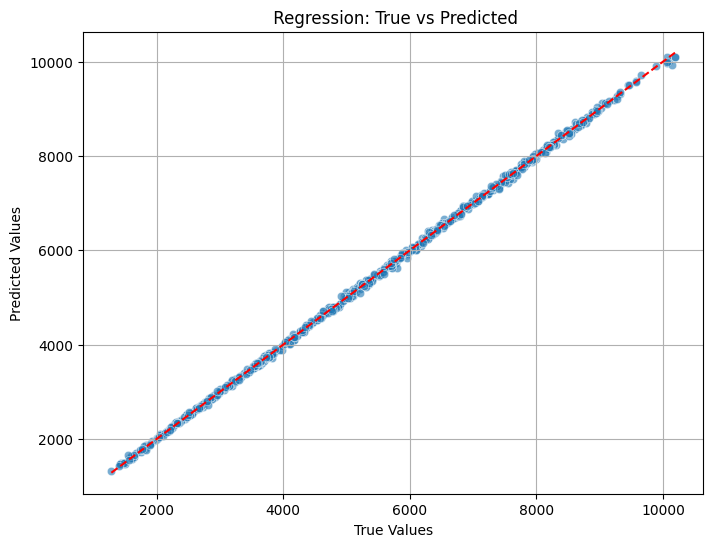

In [29]:
# Scatter Plot 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_valid, y=y_valid_pred, alpha=0.6)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(" Regression: True vs Predicted")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  
plt.grid(True)
plt.show()

# 2) `Linear Regression`

In [30]:
model_reg=LinearRegression()
model_reg.fit(X_train_final, y_train)


LinearRegression()

In [31]:
# Evaluation of training

y_train_pred2 = model_reg.predict(X_train_final)
train_mse_reg = mean_squared_error(y_train, y_train_pred2)
train_r2_reg = r2_score(y_train, y_train_pred2)

print("Training MSE:", train_mse_reg)
print("Training R² Score:", train_r2_reg)

Training MSE: 30020.083384534784
Training R² Score: 0.9937301481719818


In [32]:
# Evaluation of testing

y_valid_pred2 = model_reg.predict(X_valid_final)
test_mse_reg = mean_squared_error(y_valid, y_valid_pred2)
test_r2_reg = r2_score(y_valid, y_valid_pred2)
print("Test MSE:", test_mse_reg)
print("Test R² Score:", test_r2_reg)

Test MSE: 30676.53293368469
Test R² Score: 0.9937146500364517


# 3) `RandomForest`

In [33]:
model_rf=RandomForestRegressor ()
model_rf.fit(X_train_final, y_train)


RandomForestRegressor()

In [34]:
# Evaluation of training

y_train_pred3 = model_rf.predict(X_train_final)
train_mse_rf = mean_squared_error(y_train, y_train_pred3)
train_r2_rf = r2_score(y_train, y_train_pred3)

print("Training MSE:", train_mse_rf)
print("Training R² Score:", train_r2_rf)

Training MSE: 531.2614424477277
Training R² Score: 0.999889043262025


In [35]:
# Evaluation of testing

y_valid_pred3 = model_rf.predict(X_valid_final)
test_mse_rf = mean_squared_error(y_valid, y_valid_pred3)
test_r2_rf = r2_score(y_valid, y_valid_pred3)
print("Test MSE:", test_mse_rf)
print("Test R² Score:", test_r2_rf)

Test MSE: 2618.596230693036
Test R² Score: 0.9994634728194769


In [36]:


# #  pipeline to inference:

# full_pipeline = Pipeline([
#     ('preprocessor', preprocessor),   
#     ('model', model_lgb)
# ])

# full_pipeline.fit(X_train, y_train)


In [37]:
# import joblib

# joblib.dump(full_pipeline, 'full_pipeline_lgb.pkl')
# loaded_pipeline = joblib.load('full_pipeline_lgb.pkl')

# y_pred = loaded_pipeline.predict(X_test)

# test_mse_lgb = mean_squared_error(y_test, y_pred)
# test_r2_lgb = r2_score(y_test, y_pred)
# print("Test MSE:", test_mse_lgb)
# print("Test R² Score:", test_r2_lgb)